# One-Dimensional State Propagation
State propagation is often described deterministically, at first, using a differential equation. For stochastic state propagation, Gaussian models require linear differential equations. Here we illustrate the process going from a differential equation to modeling stochastic state propagation both for linear and nonlinear differential equations. Through Monte-Carlo simulations, qualitative assessment of Gaussianity of the final state is demonstrated using QQ plots.

In [1]:
# Setup
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.style.use('default')
import statsmodels.api as sm    # qqplot

import os
print(os.environ['CONDA_DEFAULT_ENV'])

# Helper function
def qqplot(data,mu,sigma2,title=""):
    '''QQ-Plot of scalar data against parameterized Gaussian'''
    sm.qqplot(data, loc = mu, scale = np.sqrt(sigma2) ,  line='45')
    plt.text(0.6, 0.2, 'Gaussian\n$\mu$ = %.4g\n$\sigma^2$ = %.4g'%(mu[0],sigma2[0]), 
             bbox=dict(fill="True", edgecolor='red', linewidth=2, facecolor='w'), transform=plt.gca().transAxes)    
    plt.grid()
    if title:
        plt.title(title)


stateest


## Example Differential Equations
We provide two example differential equations with known solutions. Linear functions of Guassian random variables produce Guassian-distributed results. For a linear differential equation, the Gaussian model is accurate. However, state propagation through a non-linear differential equation does not produce Gaussian data.

# Linear, first-order
| | Expression |
| --- | --- |
| Differential equation | $ \dot{y} = \alpha y $ |
| Solution | $ y(t) = \exp(t\alpha)y_0$ |
| Propagation | $ f(y;\tau):=\exp(\tau\alpha)y(t)$ |
| Jacobian | $ \frac{\partial f }{\partial y} :=\exp(\tau\alpha)$ |

# Non-Linear, first order
| | Expression |
| --- | --- |
| Differential equation | $ \dot{y} = y^2 $ |
| Solution | $ y(t) = \frac{y_0}{1-t y_0}$ |
| Propagation | $ f(y;\tau):=\frac{y(t)}{1-\tau y(t)}$ |
| Jacobian | $ \frac{\partial f }{\partial y} :=(1-\tau y )^{-2}$ |

### Problem definition

In [2]:
LINEAR_DIFF_EQ = False

if LINEAR_DIFF_EQ:
    # Model parameters
    alpha = 3

    # Functions
    state_diff = lambda tau, y : alpha*y
    prop_eval = lambda tau, y : np.exp(alpha * tau)*y
    prop_jacob = lambda tau, y : np.exp(alpha * tau)       
    
else:
    # Functions
    state_diff = lambda tau, y : y**2
    prop_eval = lambda tau, y : np.divide(y,1-tau*y)
    prop_jacob = lambda tau, y : np.divide(1,(1-tau*y)**2)

# Domain
t_all = np.linspace(0, 0.3, 100)
yInit = np.ones(1)

### Validate Consistency Between Differential and Propagation Equation
In a deterministic sense, state propagation requires solving an initial-value problem given an initial value and a differential equation. First we validate the propagation equation using the differential equation and a built-in solver.

Max step size = 3.03e-03


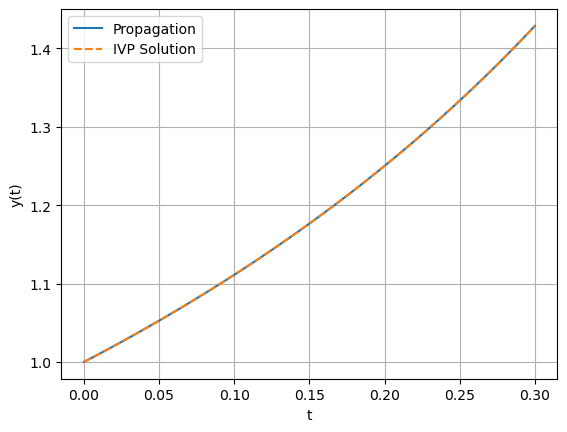

In [3]:
# Propagation equation
y_prop = prop_eval(t_all,yInit)
plt.plot(t_all, y_prop,label="Propagation")

# IVP solution using SciPy built-in solver. Smaller step sizes improve solution fidelity.
tau_max = np.median(np.diff(t_all))
#tau_max = np.Inf
print("Max step size = %.2e"%tau_max)
rslt = scipy.integrate.solve_ivp(state_diff, t_all[[0,-1]], yInit, max_step = tau_max)
plt.plot(rslt.t, rslt.y[0,:],'--',label="IVP Solution")

plt.legend()
plt.xlabel('t')
plt.ylabel('y(t)')
plt.grid()
plt.show()

### Stochastic Initial Value
The Jacobian is used to propagate uncertainty in time. To validate the Jacobian, we can perform a Monte-Carlo simulation propagating random realizations of the initial values. First we start by defining a distribution for the initial value and generating realizations.

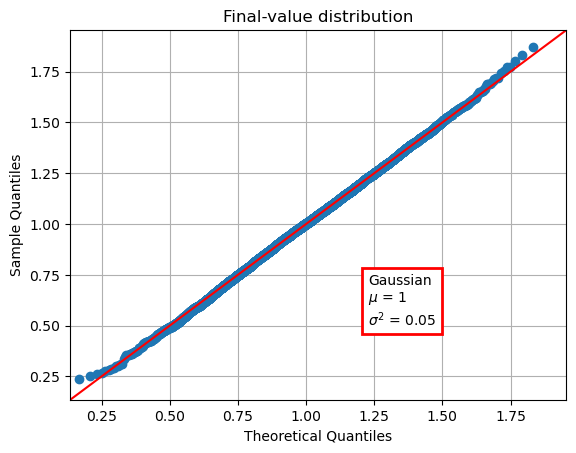

In [4]:
# Generate initial condition
mu_0 = yInit
P_0 = np.array([0.05])
rng = np.random.default_rng(12345)
y_0 = rng.normal(mu_0,np.sqrt(P_0),10000)

assert min(y_0)>0, "This propagation equation requires positive initial-values"

# Compare fit        
qqplot(y_0,mu_0,P_0,title="Final-value distribution")
plt.show()

### Stochastic Final Values
The final-value distribution can be approximated by propagating each initial-value realization. Here we compare the result with the expected distribution. The expected distribution is parameterized by the initial distribution and propagated using the Jacobian.

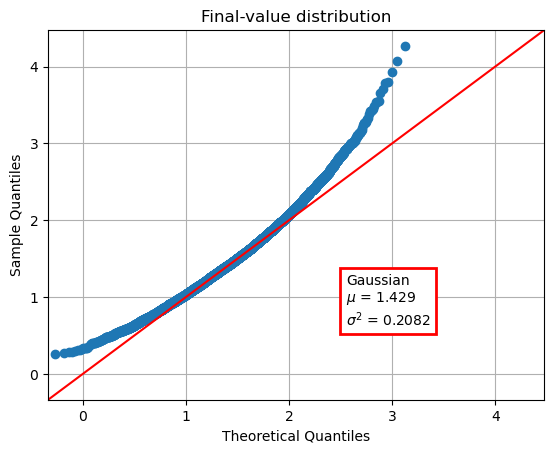

In [5]:
# For each realization of y_0, compute y_t
y_t = np.zeros(y_0.shape)
t = t_all[[-1]]
for idx, this_y0 in enumerate(y_0):
    y_t[idx] = prop_eval(t,this_y0)[0]

# Theoretical distribution after propagation
mu_t = prop_eval(t,mu_0)
F = prop_jacob(t, mu_0)
# Covariance propagation
P_t = F*P_0*F

# Compare fit        
qqplot(y_t,mu_t,P_t,title="Final-value distribution")
plt.show()

## Stochastic Process
Additive process noise can preserve Gaussian distribution - if differential equation is linear.

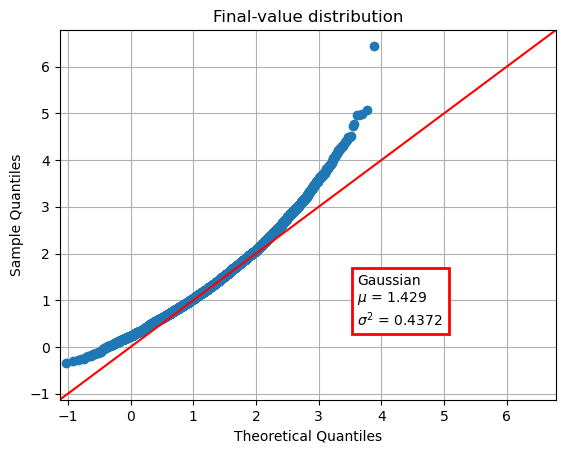

In [6]:
R_t = 0.001

if R_t == 0.0:
    r = np.zeros([t_all.size,y_0.size])
else:
    r = rng.normal(0,np.sqrt(R_t),[t_all.size,y_0.size])

# For each realization of y_0, compute y_t
y_t = np.zeros(r.shape)
y_t[0,:] = y_0
# Propagate distribution
P_t = P_0
mu_t = mu_0

for idx_t in range(1,t_all.size):
    tau = t_all[idx_t]-t_all[idx_t-1]
    #print("t index %d, tau = %g"%(idx_t,tau))
    
    for idx_y in range(0,y_0.size):
        #print("\t y index %d"%idx_y)
        y_last = y_t[idx_t-1,idx_y]
        y_next = prop_eval(tau,y_last) + r[idx_t,idx_y]
        y_t[idx_t,idx_y] = y_next

    # Theoretical distribution after propagation
    mu_t = prop_eval(tau,mu_t)
    F = prop_jacob(tau, mu_t)
    # Covariance propagation
    P_t = F*P_t*F + R_t
        
# Compare fit        
qqplot(y_t[-1,:],mu_t,P_t,title="Final-value distribution")
plt.show()

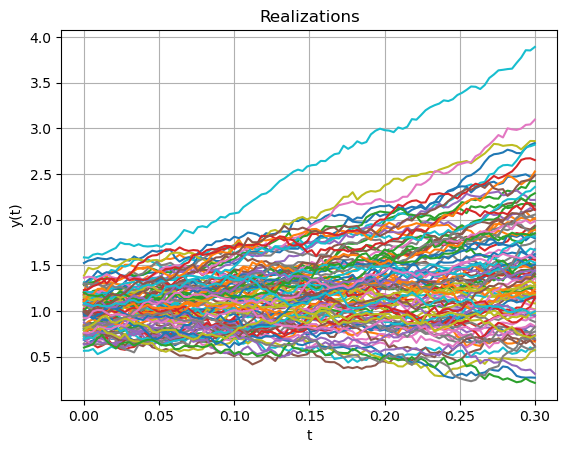

Relative error in mean: 13.32% Std.Dev.


In [7]:
# Sanity check - visualize realizations and compare Monte-Carlo mean to propagated
plt.plot(t_all,y_t[:,0:100])
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Realizations')
plt.grid()
plt.show()

print("Relative error in mean: %.2f%% Std.Dev."%(100*np.abs(np.mean(y_t[-1,:]) - mu_t)/np.sqrt(P_t))[0])
